# PITiness Assessment Methods for IRB PD Models

This notebook implements various methods to quantify the Point-in-Time (PIT) characteristics of Probability of Default (PD) models.

**Methods Implemented:**
1. PRA Cyclicality Formula (Bank of England SS11/13)
2. Correlation Test (PD vs DR)
3. Variance Ratio
4. Regression Beta
5. Carlehed-Petrov λ (PITness parameter)
6. Z-Score Volatility Ratio
7. Migration-Based PITiness (IIF/GCD approach)

**Interpretation Guide:**
- Values closer to **1 (or 100%)** indicate **PIT** behavior
- Values closer to **0 (or 0%)** indicate **TTC** behavior

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)
np.random.seed(42)

## 1. Sample Data Generation

We create realistic time series for multiple countries with varying degrees of PITiness.
- **Actual DR**: Observed default rates (ground truth)
- **Model PD**: Estimated PDs from the model being assessed

In [2]:
def generate_pd_dr_series(n_years=15, base_dr=0.02, volatility=0.3, pitiness=0.7, seed=None):
    """
    Generate correlated PD and DR time series with controlled PITiness.
    
    Parameters:
    -----------
    n_years : int - Number of annual observations
    base_dr : float - Long-run average default rate
    volatility : float - Volatility of default rates
    pitiness : float - True PITiness (0=TTC, 1=PIT)
    
    Returns:
    --------
    tuple: (actual_dr, model_pd) arrays
    """
    if seed:
        np.random.seed(seed)
    
    # Generate economic cycle (systematic factor Z)
    z_factor = np.zeros(n_years)
    z_factor[0] = np.random.normal(0, 1)
    for t in range(1, n_years):
        z_factor[t] = 0.7 * z_factor[t-1] + np.random.normal(0, 0.7)  # AR(1) process
    
    # Generate actual default rates using Vasicek framework
    rho = 0.15  # Asset correlation
    k = stats.norm.ppf(base_dr)
    
    actual_dr = np.zeros(n_years)
    for t in range(n_years):
        # PIT default rate from Vasicek
        threshold = (k - np.sqrt(rho) * z_factor[t]) / np.sqrt(1 - rho)
        actual_dr[t] = stats.norm.cdf(threshold)
        # Add idiosyncratic noise
        actual_dr[t] *= (1 + np.random.normal(0, 0.1))
    
    actual_dr = np.clip(actual_dr, 0.001, 0.30)  # Bound DRs
    
    # Generate model PDs based on PITiness
    ttc_pd = base_dr * np.ones(n_years)  # Pure TTC = constant
    pit_pd = actual_dr.copy()  # Pure PIT = tracks DR
    
    # Hybrid: blend based on pitiness parameter
    model_pd = pitiness * pit_pd + (1 - pitiness) * ttc_pd
    model_pd += np.random.normal(0, 0.002, n_years)  # Add noise
    model_pd = np.clip(model_pd, 0.001, 0.30)
    
    return actual_dr, model_pd, z_factor

In [3]:
# Generate data for multiple countries with different PITiness characteristics
countries_config = {
    'UK_Mortgages': {'base_dr': 0.015, 'volatility': 0.25, 'pitiness': 0.25, 'seed': 1},
    'Germany_Corporate': {'base_dr': 0.025, 'volatility': 0.35, 'pitiness': 0.60, 'seed': 2},
    'Spain_SME': {'base_dr': 0.045, 'volatility': 0.45, 'pitiness': 0.85, 'seed': 3},
    'France_Retail': {'base_dr': 0.030, 'volatility': 0.30, 'pitiness': 0.50, 'seed': 4},
    'Italy_Corporate': {'base_dr': 0.040, 'volatility': 0.40, 'pitiness': 0.70, 'seed': 5},
    'Netherlands_Mortgage': {'base_dr': 0.012, 'volatility': 0.20, 'pitiness': 0.20, 'seed': 6},
    'Poland_Consumer': {'base_dr': 0.055, 'volatility': 0.50, 'pitiness': 0.90, 'seed': 7},
    'Sweden_Corporate': {'base_dr': 0.020, 'volatility': 0.28, 'pitiness': 0.40, 'seed': 8},
}

# Store generated data
data = {}
years = list(range(2010, 2025))

for country, config in countries_config.items():
    dr, model_pd_arr, z = generate_pd_dr_series(
        n_years=len(years),
        base_dr=config['base_dr'],
        volatility=config['volatility'],
        pitiness=config['pitiness'],
        seed=config['seed']
    )
    data[country] = {
        'actual_dr': dr,
        'model_pd': model_pd_arr,
        'z_factor': z,
        'true_pitiness': config['pitiness']
    }

# Display sample data
sample_df = pd.DataFrame({
    'Year': years,
    'UK_DR': data['UK_Mortgages']['actual_dr'],
    'UK_PD': data['UK_Mortgages']['model_pd'],
    'Germany_DR': data['Germany_Corporate']['actual_dr'],
    'Germany_PD': data['Germany_Corporate']['model_pd'],
})
print("Sample Data (first 5 years):")
print(sample_df.head())

Sample Data (first 5 years):
   Year  UK_DR  UK_PD  Germany_DR  Germany_PD
0  2010 0.0011 0.0101      0.0240      0.0239
1  2011 0.0039 0.0114      0.0234      0.0285
2  2012 0.0073 0.0117      0.0902      0.0592
3  2013 0.0191 0.0143      0.0165      0.0201
4  2014 0.0084 0.0120      0.0570      0.0450


## 2. PITiness Calculation Methods

### Method 1: PRA Cyclicality Formula (Bank of England SS11/13)

$$\text{Cyclicality\%} = \frac{\sum|PD_t - PD_{t-1}|}{\sum|DR_t - DR_{t-1}|} \times 100$$

This measures what proportion of DR volatility is captured by PD movements.

In [4]:
def pra_cyclicality(model_pd, actual_dr):
    """
    PRA Cyclicality Formula from SS11/13.
    
    Measures the proportion of default rate changes explained by PD changes.
    
    Returns: Cyclicality percentage (0-100%, higher = more PIT)
    """
    pd_changes = np.abs(np.diff(model_pd))
    dr_changes = np.abs(np.diff(actual_dr))
    
    # Avoid division by zero
    if np.sum(dr_changes) < 1e-10:
        return np.nan
    
    cyclicality = np.sum(pd_changes) / np.sum(dr_changes)
    return min(cyclicality, 1.0)  # Cap at 100%

### Method 2: Correlation Test

$$\text{PITiness} = Corr(PD_{model}, DR_{actual})$$

Simple Pearson correlation between model PDs and observed default rates.

In [5]:
def correlation_pitiness(model_pd, actual_dr):
    """
    Correlation-based PITiness measure.
    
    Returns: Correlation coefficient (0-1, higher = more PIT)
    """
    corr, _ = stats.pearsonr(model_pd, actual_dr)
    return max(0, corr)  # Floor at 0 for interpretability

### Method 3: Variance Ratio

$$\text{PITiness} = \frac{Var(PD_{model})}{Var(DR_{actual})}$$

Ratio of model PD variance to actual DR variance.

In [6]:
def variance_ratio_pitiness(model_pd, actual_dr):
    """
    Variance ratio PITiness measure.
    
    Returns: Variance ratio (0-1+, values near 1 indicate PIT)
    """
    var_pd = np.var(model_pd)
    var_dr = np.var(actual_dr)
    
    if var_dr < 1e-10:
        return np.nan
    
    ratio = var_pd / var_dr
    return min(ratio, 1.0)  # Cap at 1

### Method 4: Regression Beta

$$PD_{model} = \alpha + \beta \cdot DR_{actual} + \varepsilon$$

The slope coefficient β indicates how strongly PDs respond to DR changes.

In [7]:
def regression_beta_pitiness(model_pd, actual_dr):
    """
    Regression-based PITiness (beta coefficient).
    
    Returns: Beta coefficient (0-1, higher = more PIT)
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(actual_dr, model_pd)
    return max(0, min(slope, 1.0))  # Bound between 0 and 1

### Method 5: Carlehed-Petrov λ (PITness Parameter)

Based on the Vasicek framework:

$$PD_{hybrid} = \Phi\left[\frac{\Phi^{-1}(PD_{TTC}) - \lambda\sqrt{\rho} \cdot Z}{\sqrt{1 - \lambda^2\rho}}\right]$$

We estimate λ by minimizing the squared error between model PDs and the theoretical hybrid PDs.

In [8]:
def carlehed_petrov_lambda(model_pd, actual_dr, rho=0.15):
    """
    Carlehed-Petrov PITness parameter (λ) estimation.
    
    Uses optimization to find λ that best explains the model PD behavior.
    
    Parameters:
    -----------
    model_pd : array - Model PD estimates
    actual_dr : array - Observed default rates
    rho : float - Asset correlation parameter (default 0.15)
    
    Returns: λ (0-1, higher = more PIT)
    """
    # Estimate TTC PD as long-run average
    pd_ttc = np.mean(actual_dr)
    k = stats.norm.ppf(pd_ttc)
    
    # Extract Z factors from observed DRs
    z_factors = np.zeros(len(actual_dr))
    for t in range(len(actual_dr)):
        dr_t = np.clip(actual_dr[t], 0.0001, 0.9999)
        z_factors[t] = (k - np.sqrt(1 - rho) * stats.norm.ppf(dr_t)) / np.sqrt(rho)
    
    def objective(lambda_param):
        """Minimize squared error between model and theoretical hybrid PD"""
        hybrid_pd = np.zeros(len(actual_dr))
        for t in range(len(actual_dr)):
            denom = np.sqrt(1 - lambda_param**2 * rho)
            if denom < 0.01:
                denom = 0.01
            numer = k - lambda_param * np.sqrt(rho) * z_factors[t]
            hybrid_pd[t] = stats.norm.cdf(numer / denom)
        
        return np.sum((model_pd - hybrid_pd)**2)
    
    # Optimize λ
    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    return result.x

### Method 6: Z-Score Volatility Ratio

$$\text{PITiness} = \frac{Std(\Phi^{-1}(PD_{model}))}{Std(\Phi^{-1}(DR_{actual}))}$$

Compares the volatility of transformed PDs to transformed DRs in the normal space.

In [9]:
def zscore_volatility_ratio(model_pd, actual_dr):
    """
    Z-score volatility ratio PITiness measure.
    
    Compares volatility in normal (probit) space.
    
    Returns: Volatility ratio (0-1, higher = more PIT)
    """
    # Transform to normal space (probit)
    pd_clipped = np.clip(model_pd, 0.0001, 0.9999)
    dr_clipped = np.clip(actual_dr, 0.0001, 0.9999)
    
    z_pd = stats.norm.ppf(pd_clipped)
    z_dr = stats.norm.ppf(dr_clipped)
    
    std_z_pd = np.std(z_pd)
    std_z_dr = np.std(z_dr)
    
    if std_z_dr < 1e-10:
        return np.nan
    
    ratio = std_z_pd / std_z_dr
    return min(ratio, 1.0)

### Method 7: First-Difference Correlation

$$\text{PITiness} = Corr(\Delta PD_t, \Delta DR_t)$$

Correlation of year-over-year changes (captures co-movement dynamics).

In [10]:
def first_diff_correlation(model_pd, actual_dr):
    """
    First-difference correlation PITiness.
    
    Measures co-movement of changes rather than levels.
    
    Returns: Correlation of changes (0-1, higher = more PIT)
    """
    pd_diff = np.diff(model_pd)
    dr_diff = np.diff(actual_dr)
    
    if len(pd_diff) < 3:
        return np.nan
    
    corr, _ = stats.pearsonr(pd_diff, dr_diff)
    return max(0, corr)

### Method 8: R-Squared from Regression

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Proportion of DR variance explained by the model PD.

In [11]:
def r_squared_pitiness(model_pd, actual_dr):
    """
    R-squared from regressing DR on model PD.
    
    Returns: R² (0-1, higher = more PIT)
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(model_pd, actual_dr)
    return r_value**2

## 3. Calculate PITiness for All Countries

In [12]:
# Define all methods
methods = {
    'PRA_Cyclicality': pra_cyclicality,
    'Correlation': correlation_pitiness,
    'Variance_Ratio': variance_ratio_pitiness,
    'Regression_Beta': regression_beta_pitiness,
    'Carlehed_Petrov_λ': carlehed_petrov_lambda,
    'ZScore_Vol_Ratio': zscore_volatility_ratio,
    'FirstDiff_Corr': first_diff_correlation,
    'R_Squared': r_squared_pitiness,
}

# Calculate PITiness for each country and method
results = []

for country, series_data in data.items():
    row = {'Country_Portfolio': country, 'True_PITiness': series_data['true_pitiness']}
    
    for method_name, method_func in methods.items():
        try:
            pitiness_value = method_func(
                series_data['model_pd'],
                series_data['actual_dr']
            )
            row[method_name] = pitiness_value
        except Exception as e:
            row[method_name] = np.nan
    
    results.append(row)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Country_Portfolio')

In [13]:
# Display main results table
print("="*100)
print("PITiness Assessment Results by Country/Portfolio and Method")
print("="*100)
print("\nInterpretation: Values closer to 1.0 indicate PIT behavior, closer to 0.0 indicate TTC behavior")
print("\n")
display_df = results_df.copy()
display_df

PITiness Assessment Results by Country/Portfolio and Method

Interpretation: Values closer to 1.0 indicate PIT behavior, closer to 0.0 indicate TTC behavior




,True_PITiness,PRA_Cyclicality,Correlation,Variance_Ratio,Regression_Beta,Carlehed_Petrov_λ,ZScore_Vol_Ratio,FirstDiff_Corr,R_Squared
Country_Portfolio,,,,,,,,,
UK_Mortgages,0.2500,0.3470,0.8412,0.1100,0.2790,0.2675,0.2573,0.9012,0.7076
Germany_Corporate,0.6000,0.6135,0.9889,0.3337,0.5713,0.5501,0.5996,0.9810,0.9780
Spain_SME,0.8500,0.8662,0.9956,0.6901,0.8271,0.8052,0.7417,0.9893,0.9912
France_Retail,0.5000,0.6224,0.9881,0.3591,0.5921,0.6300,0.6130,0.9860,0.9763
Italy_Corporate,0.7000,0.6921,0.9976,0.4844,0.6943,0.6900,0.5698,0.9911,0.9952
Netherlands_Mortgage,0.2000,0.3423,0.8372,0.0590,0.2033,0.2389,0.2516,0.8081,0.7009
Poland_Consumer,0.9000,0.9317,0.9947,0.8789,0.9326,0.9431,0.8567,0.9907,0.9895
Sweden_Corporate,0.4000,0.4161,0.9961,0.1646,0.4041,0.5096,0.3596,0.9950,0.9922


In [14]:
# Create a styled version with conditional formatting
def color_pitiness(val):
    """Color code PITiness values: green=PIT, red=TTC"""
    if pd.isna(val):
        return ''
    if val > 0.7:
        return 'background-color: #90EE90'  # Light green (PIT)
    elif val > 0.4:
        return 'background-color: #FFFFE0'  # Light yellow (Hybrid)
    else:
        return 'background-color: #FFB6C1'  # Light red (TTC)

styled_df = results_df.style.applymap(
    color_pitiness, 
    subset=[col for col in results_df.columns if col != 'True_PITiness']
)
styled_df

,True_PITiness,PRA_Cyclicality,Correlation,Variance_Ratio,Regression_Beta,Carlehed_Petrov_λ,ZScore_Vol_Ratio,FirstDiff_Corr,R_Squared
Country_Portfolio,,,,,,,,,
UK_Mortgages,0.250000,0.347025,0.841188,0.109997,0.278986,0.267535,0.257258,0.901168,0.707597
Germany_Corporate,0.600000,0.613501,0.988936,0.333715,0.571289,0.550077,0.599561,0.980957,0.977994
Spain_SME,0.850000,0.866176,0.995600,0.690143,0.827093,0.805203,0.741735,0.989271,0.991220
France_Retail,0.500000,0.622442,0.988073,0.359142,0.592137,0.630003,0.613008,0.986029,0.976288
Italy_Corporate,0.700000,0.692102,0.997581,0.484390,0.694298,0.690044,0.569763,0.991080,0.995169
Netherlands_Mortgage,0.200000,0.342263,0.837173,0.058950,0.203263,0.238906,0.251591,0.808129,0.700858
Poland_Consumer,0.900000,0.931726,0.994721,0.878931,0.932564,0.943080,0.856734,0.990683,0.989469
Sweden_Corporate,0.400000,0.416109,0.996115,0.164560,0.404083,0.509557,0.359585,0.994955,0.992245


## 4. Method Comparison and Validation

In [15]:
# Calculate correlation of each method with true PITiness
method_cols = [col for col in results_df.columns if col != 'True_PITiness']

method_performance = {}
for method in method_cols:
    valid_mask = ~results_df[method].isna()
    if valid_mask.sum() > 2:
        corr, _ = stats.pearsonr(
            results_df.loc[valid_mask, 'True_PITiness'],
            results_df.loc[valid_mask, method]
        )
        mae = np.mean(np.abs(
            results_df.loc[valid_mask, 'True_PITiness'] - 
            results_df.loc[valid_mask, method]
        ))
        method_performance[method] = {'Correlation_with_True': corr, 'MAE': mae}

performance_df = pd.DataFrame(method_performance).T
performance_df = performance_df.sort_values('Correlation_with_True', ascending=False)

print("\n" + "="*60)
print("Method Performance vs True PITiness")
print("="*60)
print("\nHigher correlation and lower MAE indicate better method accuracy\n")
performance_df


Method Performance vs True PITiness

Higher correlation and lower MAE indicate better method accuracy



,Correlation_with_True,MAE
Regression_Beta,0.9889,0.0273
PRA_Cyclicality,0.9826,0.0559
Carlehed_Petrov_λ,0.9681,0.0555
Variance_Ratio,0.9667,0.1650
ZScore_Vol_Ratio,0.9573,0.0618
R_Squared,0.7806,0.3664
Correlation,0.7800,0.4049
FirstDiff_Corr,0.7322,0.4053


In [16]:
# Summary statistics by method
print("\n" + "="*60)
print("Summary Statistics by Method")
print("="*60 + "\n")

summary_stats = results_df[method_cols].describe().T
summary_stats['range'] = summary_stats['max'] - summary_stats['min']
summary_stats


Summary Statistics by Method



,count,mean,std,min,25%,50%,75%,max,range
PRA_Cyclicality,8.0000,0.6039,0.2249,0.3423,0.3988,0.6180,0.7356,0.9317,0.5895
Correlation,8.0000,0.9549,0.0715,0.8372,0.9514,0.9918,0.9957,0.9976,0.1604
Variance_Ratio,8.0000,0.3850,0.2880,0.0590,0.1509,0.3464,0.5358,0.8789,0.8200
Regression_Beta,8.0000,0.5630,0.2563,0.2033,0.3728,0.5817,0.7275,0.9326,0.7293
Carlehed_Petrov_λ,8.0000,0.5793,0.2441,0.2389,0.4491,0.5900,0.7188,0.9431,0.7042
ZScore_Vol_Ratio,8.0000,0.5312,0.2223,0.2516,0.3340,0.5847,0.6452,0.8567,0.6051
FirstDiff_Corr,8.0000,0.9553,0.0670,0.8081,0.9610,0.9877,0.9908,0.9950,0.1868
R_Squared,8.0000,0.9164,0.1311,0.7009,0.9091,0.9837,0.9915,0.9952,0.2943


## 5. Detailed Output Table

In [17]:
# Create final comprehensive table
final_table = results_df.copy()

# Add average across methods (excluding True_PITiness)
final_table['Avg_Estimated'] = final_table[method_cols].mean(axis=1)
final_table['Std_Across_Methods'] = final_table[method_cols].std(axis=1)

# Reorder columns
col_order = ['True_PITiness'] + method_cols + ['Avg_Estimated', 'Std_Across_Methods']
final_table = final_table[col_order]

print("\n" + "="*120)
print("FINAL PITiness ASSESSMENT TABLE")
print("="*120)
print("\nRows: Country/Portfolio pairs | Columns: PITiness methods")
print("Values: PITiness score (0=TTC, 1=PIT)")
print("\n")
final_table.round(4)


FINAL PITiness ASSESSMENT TABLE

Rows: Country/Portfolio pairs | Columns: PITiness methods
Values: PITiness score (0=TTC, 1=PIT)




,True_PITiness,PRA_Cyclicality,Correlation,Variance_Ratio,Regression_Beta,Carlehed_Petrov_λ,ZScore_Vol_Ratio,FirstDiff_Corr,R_Squared,Avg_Estimated,Std_Across_Methods
Country_Portfolio,,,,,,,,,,,
UK_Mortgages,0.2500,0.3470,0.8412,0.1100,0.2790,0.2675,0.2573,0.9012,0.7076,0.4638,0.3041
Germany_Corporate,0.6000,0.6135,0.9889,0.3337,0.5713,0.5501,0.5996,0.9810,0.9780,0.7020,0.2480
Spain_SME,0.8500,0.8662,0.9956,0.6901,0.8271,0.8052,0.7417,0.9893,0.9912,0.8633,0.1190
France_Retail,0.5000,0.6224,0.9881,0.3591,0.5921,0.6300,0.6130,0.9860,0.9763,0.7209,0.2342
Italy_Corporate,0.7000,0.6921,0.9976,0.4844,0.6943,0.6900,0.5698,0.9911,0.9952,0.7643,0.2039
Netherlands_Mortgage,0.2000,0.3423,0.8372,0.0590,0.2033,0.2389,0.2516,0.8081,0.7009,0.4301,0.3041
Poland_Consumer,0.9000,0.9317,0.9947,0.8789,0.9326,0.9431,0.8567,0.9907,0.9895,0.9397,0.0518
Sweden_Corporate,0.4000,0.4161,0.9961,0.1646,0.4041,0.5096,0.3596,0.9950,0.9922,0.6047,0.3369


In [18]:
# Export to CSV for further analysis
final_table.to_csv('pitiness_results.csv')
print("\nResults exported to 'pitiness_results.csv'")


Results exported to 'pitiness_results.csv'


## 6. Method Documentation Summary

| Method | Formula | Pros | Cons |
|--------|---------|------|------|
| **PRA Cyclicality** | Σ\|ΔPD\|/Σ\|ΔDR\| | Regulatory aligned (UK); intuitive | Volatile with short series |
| **Correlation** | Corr(PD, DR) | Simple; robust | Doesn't capture magnitude |
| **Variance Ratio** | Var(PD)/Var(DR) | Captures volatility matching | Sensitive to outliers |
| **Regression Beta** | β from PD=α+βDR | Captures responsiveness | Assumes linearity |
| **Carlehed-Petrov λ** | Vasicek framework | Theoretically rigorous | Requires ρ assumption |
| **Z-Score Vol Ratio** | Std(Φ⁻¹PD)/Std(Φ⁻¹DR) | Works in normal space | Transformation sensitive |
| **First-Diff Corr** | Corr(ΔPD, ΔDR) | Captures dynamics | Loses level information |
| **R-Squared** | R² from regression | Standard statistical measure | Doesn't indicate direction |

## 7. Visualization

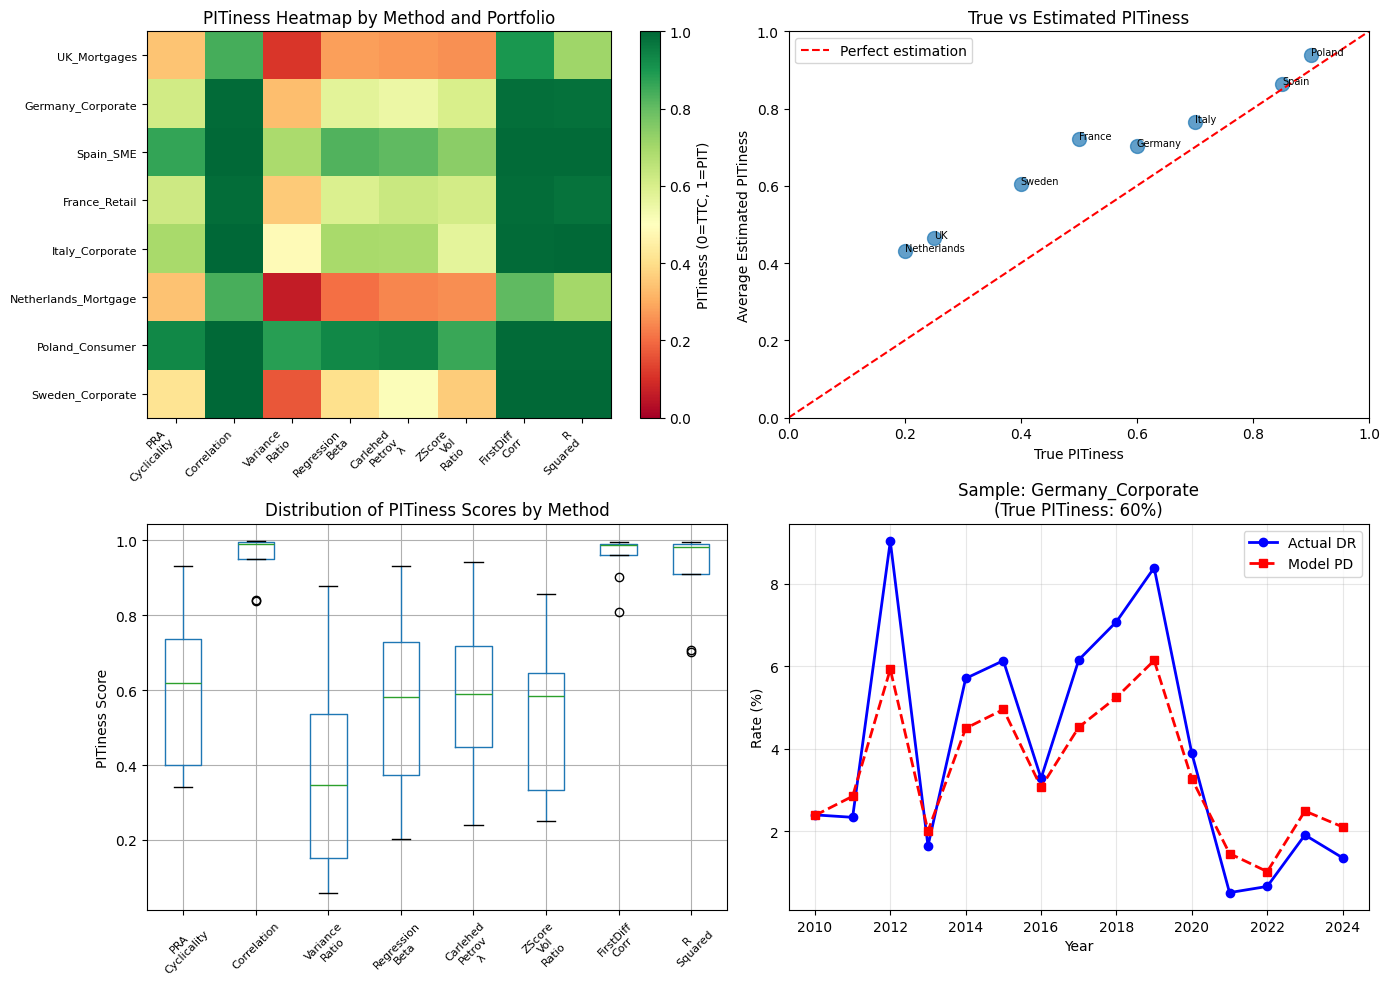


Visualization saved to 'pitiness_analysis.png'


In [19]:
import matplotlib.pyplot as plt

# Calculate summary columns first
results_df['Avg_Estimated'] = results_df[method_cols].mean(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Heatmap of results
ax1 = axes[0, 0]
heatmap_data = results_df[method_cols].values
im = ax1.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax1.set_xticks(range(len(method_cols)))
ax1.set_xticklabels([m.replace('_', '\n') for m in method_cols], rotation=45, ha='right', fontsize=8)
ax1.set_yticks(range(len(results_df)))
ax1.set_yticklabels(results_df.index, fontsize=8)
ax1.set_title('PITiness Heatmap by Method and Portfolio')
plt.colorbar(im, ax=ax1, label='PITiness (0=TTC, 1=PIT)')

# Plot 2: True vs Estimated PITiness
ax2 = axes[0, 1]
ax2.scatter(results_df['True_PITiness'], results_df['Avg_Estimated'], s=100, alpha=0.7)
ax2.plot([0, 1], [0, 1], 'r--', label='Perfect estimation')
for idx, row in results_df.iterrows():
    ax2.annotate(idx.split('_')[0], (row['True_PITiness'], row['Avg_Estimated']), fontsize=7)
ax2.set_xlabel('True PITiness')
ax2.set_ylabel('Average Estimated PITiness')
ax2.set_title('True vs Estimated PITiness')
ax2.legend()
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# Plot 3: Method comparison boxplot
ax3 = axes[1, 0]
results_df[method_cols].boxplot(ax=ax3, rot=45)
ax3.set_ylabel('PITiness Score')
ax3.set_title('Distribution of PITiness Scores by Method')
ax3.set_xticklabels([m.replace('_', '\n') for m in method_cols], fontsize=8)

# Plot 4: Sample time series
ax4 = axes[1, 1]
sample_country = 'Germany_Corporate'
ax4.plot(years, data[sample_country]['actual_dr']*100, 'b-o', label='Actual DR', linewidth=2)
ax4.plot(years, data[sample_country]['model_pd']*100, 'r--s', label='Model PD', linewidth=2)
ax4.set_xlabel('Year')
ax4.set_ylabel('Rate (%)')
ax4.set_title(f'Sample: {sample_country}\n(True PITiness: {data[sample_country]["true_pitiness"]:.0%})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pitiness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'pitiness_analysis.png'")

## 8. Applying to Your Own Data

To use these methods with your own data, replace the synthetic data with your actual time series:

In [20]:
# Example: How to use with your own data

def calculate_all_pitiness_metrics(model_pd_series, actual_dr_series, rho=0.15):
    """
    Calculate all PITiness metrics for a single portfolio.
    
    Parameters:
    -----------
    model_pd_series : array-like - Time series of model PD estimates
    actual_dr_series : array-like - Time series of observed default rates
    rho : float - Asset correlation for Carlehed-Petrov method
    
    Returns:
    --------
    dict : Dictionary of PITiness metrics
    """
    model_pd = np.array(model_pd_series)
    actual_dr = np.array(actual_dr_series)
    
    results = {
        'PRA_Cyclicality': pra_cyclicality(model_pd, actual_dr),
        'Correlation': correlation_pitiness(model_pd, actual_dr),
        'Variance_Ratio': variance_ratio_pitiness(model_pd, actual_dr),
        'Regression_Beta': regression_beta_pitiness(model_pd, actual_dr),
        'Carlehed_Petrov_λ': carlehed_petrov_lambda(model_pd, actual_dr, rho),
        'ZScore_Vol_Ratio': zscore_volatility_ratio(model_pd, actual_dr),
        'FirstDiff_Corr': first_diff_correlation(model_pd, actual_dr),
        'R_Squared': r_squared_pitiness(model_pd, actual_dr),
    }
    
    return results

# Example usage:
# your_results = calculate_all_pitiness_metrics(
#     model_pd_series=your_pd_data,
#     actual_dr_series=your_dr_data,
#     rho=0.15
# )

print("Function 'calculate_all_pitiness_metrics' ready for use with your data.")
print("\nExample output for UK_Mortgages:")
example_results = calculate_all_pitiness_metrics(
    data['UK_Mortgages']['model_pd'],
    data['UK_Mortgages']['actual_dr']
)
for metric, value in example_results.items():
    print(f"  {metric}: {value:.4f}")

Function 'calculate_all_pitiness_metrics' ready for use with your data.

Example output for UK_Mortgages:
  PRA_Cyclicality: 0.3470
  Correlation: 0.8412
  Variance_Ratio: 0.1100
  Regression_Beta: 0.2790
  Carlehed_Petrov_λ: 0.2675
  ZScore_Vol_Ratio: 0.2573
  FirstDiff_Corr: 0.9012
  R_Squared: 0.7076
